In [9]:
import pandas as pd

df = pd.read_csv('../data/processed/atp_matches_2000-2024.csv')

In [10]:
import pandas as pd

def elo_expected(rating_a: float, rating_b: float) -> float:
    """Expected score for player A vs B."""
    return 1.0 / (1.0 + 10.0 ** ((rating_b - rating_a) / 400.0))

def add_elo_columns(df: pd.DataFrame, k: float, init_rating: float) -> pd.DataFrame:
    df = df.copy()

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date"]).reset_index(drop=True)


    ratings = {}  # name -> current Elo

    elo_A_pre = []
    elo_B_pre = []
    elo_A_post = []
    elo_B_post = []

    for _, row in df.iterrows():
        a = row["player_A_name"]
        b = row["player_B_name"]
        w = row["winner_name"]

        ra = ratings.get(a, init_rating)
        rb = ratings.get(b, init_rating)

        # Record pre-match ratings
        elo_A_pre.append(ra)
        elo_B_pre.append(rb)

        # Determine result from A's perspective
        if w == a:
            sa = 1.0
        elif w == b:
            sa = 0.0
        else:
            # If winner_name doesn't match either player (bad row), skip update
            sa = None

        if sa is None:
            elo_A_post.append(ra)
            elo_B_post.append(rb)
            continue

        ea = elo_expected(ra, rb)
        eb = 1.0 - ea

        sb = 1.0 - sa

        # Update
        ra_new = ra + k * (sa - ea)
        rb_new = rb + k * (sb - eb)

        ratings[a] = ra_new
        ratings[b] = rb_new

        elo_A_post.append(ra_new)
        elo_B_post.append(rb_new)

    df["elo_A_pre"] = elo_A_pre
    df["elo_B_pre"] = elo_B_pre
    df["elo_A_post"] = elo_A_post
    df["elo_B_post"] = elo_B_post

    return df, ratings

df_with_elo, final_ratings = add_elo_columns(df, k=24, init_rating=1500)
print(df_with_elo.head())
df_with_elo.to_csv("../data/processed/atp_matches_2000-2024.csv", index=False)


        date tournament_name surface round  best_of      player_A_name  \
0 2000-01-03        Adelaide    Hard    SF        3     Lleyton Hewitt   
1 2000-01-03        Adelaide    Hard   R32        3      Roger Federer   
2 2000-01-03        Adelaide    Hard   R32        3     Thomas Enqvist   
3 2000-01-03            Doha    Hard   R32        3     Nicolas Kiefer   
4 2000-01-03            Doha    Hard   R32        3  Cristiano Caratti   

      player_B_name        winner_name           score  player_A_rank  \
0    Nicolas Escude     Lleyton Hewitt     3-6 6-1 6-4           25.0   
1  Jens Knippschild      Roger Federer         6-1 6-4           64.0   
2    Arnaud Clement     Thomas Enqvist         6-3 6-4            4.0   
3      Jeff Tarango     Nicolas Kiefer   7-6(6) 7-6(6)            6.0   
4     Ivo Heuberger  Cristiano Caratti  7-6(4) 4-6 6-4          213.0   

   player_B_rank  player_A_rank_points  player_B_rank_points  elo_A_pre  \
0           37.0                1429.0   

In [11]:
""" View top 20 players by final Elo rating """

# Convert final_ratings dictionary to DataFrame
final_ratings_df = pd.DataFrame([
    {'player': player, 'elo': rating}
    for player, rating in final_ratings.items()
]).sort_values('elo', ascending=False)

print("Top 20 players by Elo rating:")
print(final_ratings_df.head(20))

Top 20 players by Elo rating:
                     player          elo
2244          Jannik Sinner  2156.721726
938          Novak Djokovic  2080.787955
2292         Carlos Alcaraz  2013.157144
2             Roger Federer  2007.870612
630         Robin Soderling  1991.280244
1807       Alexander Zverev  1954.189888
1120  Juan Martin del Potro  1924.331789
1950           Taylor Fritz  1911.198945
2036        Daniil Medvedev  1900.220331
1793           Nick Kyrgios  1897.567546
681            Rafael Nadal  1887.324949
1385        Grigor Dimitrov  1864.874719
2073         Alex De Minaur  1861.117052
2357            Jack Draper  1846.704328
2204            Holger Rune  1834.953811
2189        Sebastian Korda  1821.423189
269            Andy Roddick  1820.677794
2104     Stefanos Tsitsipas  1818.626193
2007         Hubert Hurkacz  1816.665945
1976             Tommy Paul  1816.262307


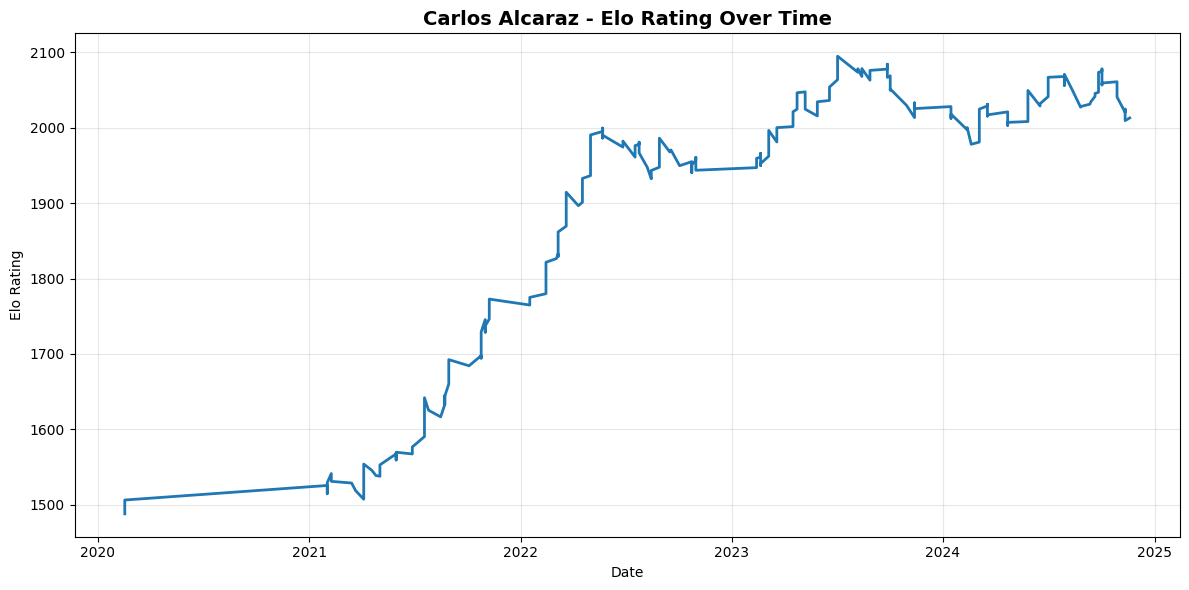

Total matches: 265
Peak Elo: 2095
Current Elo: 2013


In [12]:
""" Plot Elo rating history for any player """

import matplotlib.pyplot as plt

def plot_player_elo(player_name):
    """Plot Elo rating history for a given player"""
    
    # Filter for player's matches
    player_matches = df_with_elo[
        (df_with_elo['player_A_name'] == player_name) | 
        (df_with_elo['player_B_name'] == player_name)
    ].copy()
    
    if len(player_matches) == 0:
        print(f"No matches found for {player_name}")
        return
    
    # Get Elo rating after each match
    elo_history = []
    for idx, row in player_matches.iterrows():
        if row['player_A_name'] == player_name:
            elo_history.append({
                'date': row['date'],
                'elo': row['elo_A_post']
            })
        else:
            elo_history.append({
                'date': row['date'],
                'elo': row['elo_B_post']
            })
    
    player_df = pd.DataFrame(elo_history)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(player_df['date'], player_df['elo'], linewidth=2)
    plt.title(f'{player_name} - Elo Rating Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Elo Rating')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Total matches: {len(player_df)}")
    print(f"Peak Elo: {player_df['elo'].max():.0f}")
    print(f"Current Elo: {player_df['elo'].iloc[-1]:.0f}")

# Example usage
plot_player_elo('Carlos Alcaraz')

In [13]:
""" Surface-specific Elo Rating System """

def add_surface_elo_columns(df: pd.DataFrame, k: float, init_rating: float) -> pd.DataFrame:
    """Calculate surface-specific Elo ratings for each surface"""
    df = df.copy()
    
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date"]).reset_index(drop=True)
    
    # Separate ratings for each surface
    ratings = {
        'Hard': {},
        'Clay': {},
        'Grass': {}
    }
    
    # Pre-match and post-match rating columns for each surface
    surface_columns = {}
    for surface in ['Hard', 'Clay', 'Grass']:
        surface_columns[surface] = {
            'A_pre': [],
            'B_pre': [],
            'A_post': [],
            'B_post': []
        }
    
    for _, row in df.iterrows():
        a = row["player_A_name"]
        b = row["player_B_name"]
        w = row["winner_name"]
        surface = row["surface"]
        
        # Skip if surface not in our tracked surfaces
        if surface not in ratings:
            for s in ratings:
                surface_columns[s]['A_pre'].append(None)
                surface_columns[s]['B_pre'].append(None)
                surface_columns[s]['A_post'].append(None)
                surface_columns[s]['B_post'].append(None)
            continue
        
        # Get pre-match ratings
        ra = ratings[surface].get(a, init_rating)
        rb = ratings[surface].get(b, init_rating)
        
        # Determine result from A's perspective
        if w == a:
            sa = 1.0
        elif w == b:
            sa = 0.0
        else:
            sa = None
        
        if sa is None:
            # Skip update for bad rows
            for s in ratings:
                if s == surface:
                    surface_columns[s]['A_pre'].append(ra)
                    surface_columns[s]['B_pre'].append(rb)
                    surface_columns[s]['A_post'].append(ra)
                    surface_columns[s]['B_post'].append(rb)
                else:
                    surface_columns[s]['A_pre'].append(None)
                    surface_columns[s]['B_pre'].append(None)
                    surface_columns[s]['A_post'].append(None)
                    surface_columns[s]['B_post'].append(None)
            continue
        
        # Calculate expected scores
        ea = elo_expected(ra, rb)
        eb = 1.0 - ea
        sb = 1.0 - sa
        
        # Update ratings
        ra_new = ra + k * (sa - ea)
        rb_new = rb + k * (sb - eb)
        
        ratings[surface][a] = ra_new
        ratings[surface][b] = rb_new
        
        # Record for this surface
        surface_columns[surface]['A_pre'].append(ra)
        surface_columns[surface]['B_pre'].append(rb)
        surface_columns[surface]['A_post'].append(ra_new)
        surface_columns[surface]['B_post'].append(rb_new)
        
        # Record None for other surfaces
        for s in ratings:
            if s != surface:
                surface_columns[s]['A_pre'].append(None)
                surface_columns[s]['B_pre'].append(None)
                surface_columns[s]['A_post'].append(None)
                surface_columns[s]['B_post'].append(None)
    
    # Add columns to dataframe
    for surface in ['Hard', 'Clay', 'Grass']:
        df[f"elo_A_pre_{surface}"] = surface_columns[surface]['A_pre']
        df[f"elo_B_pre_{surface}"] = surface_columns[surface]['B_pre']
        df[f"elo_A_post_{surface}"] = surface_columns[surface]['A_post']
        df[f"elo_B_post_{surface}"] = surface_columns[surface]['B_post']
    
    return df, ratings

# Calculate surface-specific Elo ratings
df_with_surface_elo, final_surface_ratings = add_surface_elo_columns(df_with_elo, k=24, init_rating=1500)
print(df_with_surface_elo.head())

df_with_surface_elo.to_csv("../data/processed/atp_matches_2000-2024.csv", index=False)

        date tournament_name surface round  best_of        player_A_name  \
0 2000-01-03        Adelaide    Hard    SF        3       Lleyton Hewitt   
1 2000-01-03         Chennai    Hard   R32        3        Lorenzo Manta   
2 2000-01-03         Chennai    Hard   R32        3         Leander Paes   
3 2000-01-03         Chennai    Hard   R32        3   Davide Sanguinetti   
4 2000-01-03         Chennai    Hard   R32        3  Andreas Vinciguerra   

      player_B_name          winner_name        score  player_A_rank  ...  \
0    Nicolas Escude       Lleyton Hewitt  3-6 6-1 6-4           25.0  ...   
1         Tomas Zib        Lorenzo Manta      7-5 6-2          115.0  ...   
2    Julien Boutter         Leander Paes   6-4 7-6(6)          142.0  ...   
3     Adrian Voinea   Davide Sanguinetti   7-6(7) 6-4          120.0  ...   
4  Alex Lopez Moron  Andreas Vinciguerra      6-4 6-2           98.0  ...   

   elo_A_post_Hard  elo_B_post_Hard  elo_A_pre_Clay  elo_B_pre_Clay  \
0        

In [14]:
""" View top 10 players by surface-specific Elo rating """

for surface in ['Hard', 'Clay', 'Grass']:
    surface_ratings = pd.DataFrame([
        {'player': player, 'elo': rating}
        for player, rating in final_surface_ratings[surface].items()
    ]).sort_values('elo', ascending=False)
    
    print(f"\n{'='*50}")
    print(f"Top 10 players on {surface}:")
    print(surface_ratings.head(10).to_string(index=False))


Top 10 players on Hard:
               player         elo
        Jannik Sinner 2141.852919
       Novak Djokovic 2078.878920
        Roger Federer 2045.202249
Juan Martin del Potro 1963.279708
       Carlos Alcaraz 1926.040093
      Robin Soderling 1917.411582
     Alexander Zverev 1908.161737
      Daniil Medvedev 1899.376994
         Rafael Nadal 1871.866948
         Taylor Fritz 1864.318958

Top 10 players on Clay:
            player         elo
      Rafael Nadal 2010.683944
    Novak Djokovic 1994.688463
    Carlos Alcaraz 1916.343451
Stefanos Tsitsipas 1891.774617
     Roger Federer 1889.575594
  Alexander Zverev 1887.385078
   Robin Soderling 1879.151214
       Casper Ruud 1858.810568
 Matteo Berrettini 1833.696878
       Andy Murray 1830.061791

Top 10 players on Grass:
           player         elo
   Novak Djokovic 1963.034672
    Roger Federer 1925.830033
     Rafael Nadal 1794.323347
     Andy Roddick 1772.269709
      Marin Cilic 1769.511307
      Andy Murray 1752.261519

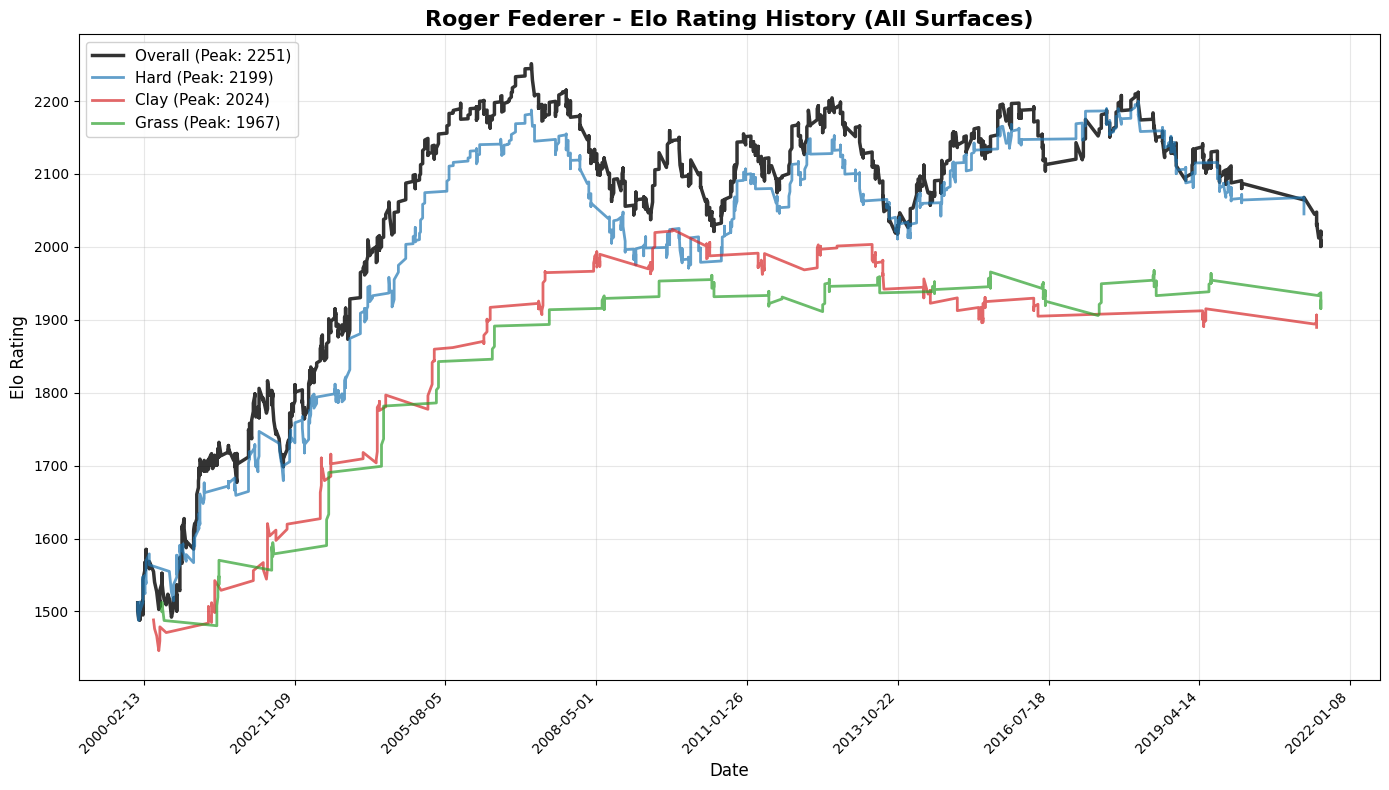

In [15]:
""" Plot all Elo ratings on a single graph """

import matplotlib.pyplot as plt

def plot_all_elos(player_name):
    """
    Plot overall Elo and surface-specific Elo ratings for a given player on one graph
    
    Args:
        player_name: Name of the player to plot
    """
    
    plt.figure(figsize=(14, 8))
    
    # Plot Overall Elo
    player_matches = df_with_elo[
        (df_with_elo['player_A_name'] == player_name) | 
        (df_with_elo['player_B_name'] == player_name)
    ].copy()
    
    if len(player_matches) > 0:
        elo_history = []
        for idx, row in player_matches.iterrows():
            if row['player_A_name'] == player_name:
                elo_history.append({'date': row['date'], 'elo': row['elo_A_post']})
            else:
                elo_history.append({'date': row['date'], 'elo': row['elo_B_post']})
        
        overall_df = pd.DataFrame(elo_history)
        plt.plot(overall_df['date'], overall_df['elo'], linewidth=2.5, color='black', 
                label=f"Overall (Peak: {overall_df['elo'].max():.0f})", alpha=0.8)
    
    # Plot Surface-specific Elos
    surfaces = ['Hard', 'Clay', 'Grass']
    colors = ['#1f77b4', '#d62728', '#2ca02c']  # Blue, Red, Green
    
    for surface, color in zip(surfaces, colors):
        surface_matches = df_with_surface_elo[
            ((df_with_surface_elo['player_A_name'] == player_name) | 
             (df_with_surface_elo['player_B_name'] == player_name)) &
            (df_with_surface_elo['surface'] == surface)
        ].copy()
        
        if len(surface_matches) > 0:
            elo_history = []
            for idx, row in surface_matches.iterrows():
                if row['player_A_name'] == player_name:
                    elo_history.append({'date': row['date'], 'elo': row[f'elo_A_post_{surface}']})
                else:
                    elo_history.append({'date': row['date'], 'elo': row[f'elo_B_post_{surface}']})
            
            surface_df = pd.DataFrame(elo_history)
            # Filter out None values
            surface_df = surface_df[surface_df['elo'].notna()]
            
            if len(surface_df) > 0:
                plt.plot(surface_df['date'], surface_df['elo'], linewidth=2, color=color,
                        label=f"{surface} (Peak: {surface_df['elo'].max():.0f})", alpha=0.7)
    
    plt.title(f'{player_name} - Elo Rating History (All Surfaces)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Elo Rating', fontsize=12)
    plt.legend(loc='best', fontsize=11, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    
    # Reduce x-axis clutter
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show ~10 date labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_all_elos('Roger Federer')

In [16]:
""" Create a CSV with all player Elo ratings """

# Combine all players from overall and surface-specific ratings
all_players = set()
all_players.update(final_ratings.keys())
for surface in ['Hard', 'Clay', 'Grass']:
    all_players.update(final_surface_ratings[surface].keys())

# Build the ratings table
ratings_data = []

for player in sorted(all_players):
    ratings_data.append({
        'player': player,
        'elo_overall': final_ratings.get(player, 1500),
        'elo_hard': final_surface_ratings['Hard'].get(player, 1500),
        'elo_clay': final_surface_ratings['Clay'].get(player, 1500),
        'elo_grass': final_surface_ratings['Grass'].get(player, 1500)
    })

df_ratings = pd.DataFrame(ratings_data)

# Sort by overall Elo
df_ratings = df_ratings.sort_values('elo_overall', ascending=False).reset_index(drop=True)

print("\nTop 10 players:")
print(df_ratings.head(10))

# Save ratings to CSV
output_path = '../data/processed/player_elo_ratings.csv'
df_ratings.to_csv(output_path, index=False)
print(f"\nSaved to {output_path}")


Top 10 players:
                  player  elo_overall     elo_hard     elo_clay    elo_grass
0          Jannik Sinner  2156.721726  2141.852919  1782.966363  1665.027876
1         Novak Djokovic  2080.787955  2078.878920  1994.688463  1963.034672
2         Carlos Alcaraz  2013.157144  1926.040093  1916.343451  1734.928209
3          Roger Federer  2007.870612  2045.202249  1889.575594  1925.830033
4        Robin Soderling  1991.280244  1917.411582  1879.151214  1633.946902
5       Alexander Zverev  1954.189888  1908.161737  1887.385078  1661.999476
6  Juan Martin del Potro  1924.331789  1963.279708  1799.766257  1699.687765
7           Taylor Fritz  1911.198945  1864.318958  1713.694686  1639.773378
8        Daniil Medvedev  1900.220331  1899.376994  1689.266832  1698.606932
9           Nick Kyrgios  1897.567546  1848.437528  1642.087291  1678.398985

Saved to ../data/processed/player_elo_ratings.csv
